# Running a multi-member hydrological ensemble on the Raven Server

Here we use birdy's WPS client to launch the GR4JCN and HMETS hydrological models on the server and analyze the outputs. 

In [1]:
from birdy import WPSClient

from ravenpy.utilities.testdata import get_file
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get(
    "WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
)
wps = WPSClient(url)

In [2]:
# The model parameters for gr4jcn and hmets. Can either be a string of comma separated values, a list, an array or a named tuple.
gr4jcn = "0.529, -3.396, 407.29, 1.072, 16.9, 0.947"
hmets = (
    "9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919, "
    "2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947"
)

# Forcing files. Raven uses the same forcing files for all and extracts the information it requires for each model.
ts = get_file("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc")

# Model configuration parameters.
config = dict(
    start_date=dt.datetime(2000, 1, 1),
    end_date=dt.datetime(2002, 1, 1),
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
)

# Launch the WPS to get the multi-model results.  Note the "gr4jcn" and "hmets" keys.
resp = wps.raven_multi_model(ts=str(ts), gr4jcn=gr4jcn, hmets=hmets, **config)

Let's see the diagnostics and the output hydrograph. 

In [3]:
# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response.
# Setting `asobj` to True will retrieve the actual files and copy the locally.
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)
print(diagnostics)
print(hydrograph)

['observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH_ALL,/tmp/pywps_process_6edfj9_e/input.nc,-0.117301,37.9493,\n', 'observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH_ALL,/tmp/pywps_process_6edfj9_e/input.nc,-3.0132,71.9223,\n']
[<xarray.Dataset>
Dimensions:     (time: 732, nbasins: 1)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Data variables:
    precip      (time) float64 ...
    q_sim       (time, nbasins) float64 ...
    q_obs       (time, nbasins) float64 ...
    q_in        (time, nbasins) float64 ...
Attributes:
    Conventions:          CF-1.6
    featureType:          timeSeries
    history:              Created on 2021-09-08 16:36:09 by Raven
    description:          Standard Output
    title:                Simulated river discharge
    references:           Craig J.R. and the Raven Development Team Raven use

The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [4]:
hydrograph[0].q_sim

<xarray.DataArray 'q_sim' (time: 732, nbasins: 1)>
array([[ 0.      ],
       [ 0.165788],
       [ 0.559366],
       ...,
       [13.407794],
       [13.330653],
       [13.25446 ]])
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

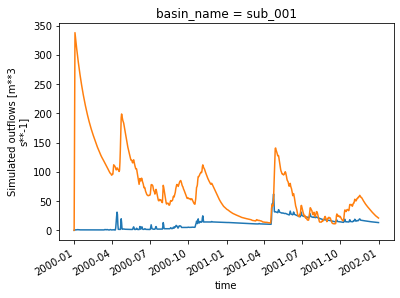

In [5]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

hydrograph[0].q_sim.plot()
hydrograph[1].q_sim.plot()

In [6]:
print("Max: ", hydrograph[0].q_sim.max())
print("Mean: ", hydrograph[0].q_sim.mean())
print("Monthly means: ", hydrograph[0].q_sim.groupby("time.month").mean(dim="time"))

Max:  <xarray.DataArray 'q_sim' ()>
array(62.23741101)
Mean:  <xarray.DataArray 'q_sim' ()>
array(11.80744727)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[ 6.9390028 ],
       [ 6.20573218],
       [ 5.94567091],
       [13.97981111],
       [15.84883309],
       [14.66198997],
       [13.20258933],
       [11.86619242],
       [10.77015304],
       [11.98581414],
       [16.00351459],
       [14.17088992]])
Coordinates:
    basin_name  (nbasins) object 'sub_001'
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins
